In [10]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATH / 'morse_dataset'
SAVE_DIR = DATASET_PATH / 'spectrogram'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}
def preload(df, fodl_name):
    transform1 = transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                      n_fft=N_FFT,
                                      hop_length=HOP_LENGTH,
                                      n_mels=N_MELS)
    
    transform2 = transforms.AmplitudeToDB(top_db=TOP_DB)

    for idx, row in df.iterrows():
        file_id = row["id"]
        audio_path = AUDIO_FILES / file_id

        try:
            waveform, sr = torchaudio.load(audio_path)
            mel_spec = transform1(waveform)
            mel_spec = transform2(mel_spec)
            torch.save(mel_spec, SAVE_DIR/fodl_name/f"{file_id}.pt")

        except Exception as e:
            print(f"Ошибка в {file_id}: {e}")

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATH,'sample_submission.csv'))

# audio_transforms = nn.Sequential(
#     transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
#     transforms.AmplitudeToDB(top_db=TOP_DB)
#     # transforms.FrequencyMasking(freq_mask_param=FREQ_MASK), 
#     # transforms.TimeMasking(time_mask_param=TIME_MASK), 
#     )
preload(test_data, 'test')



In [1]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATH / 'morse_dataset'
SAVE_DIR = DATASET_PATH / 'spectrogram'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDatasetToTest(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            file_id = self.df.id.values[index]
            spec_path = self.data_path/ f"{file_id}.pt"

            spectrogram = torch.load(spec_path)
            spec_lens = spectrogram.shape[-1]

            if self.transforms:
                spectrogram = self.transforms(spectrogram)

            if self.is_train:
                message = self.df.message.values[index]
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long)
                target_len = torch.tensor(len(target), dtype=torch.long)
                return spectrogram, spec_lens, target, target_len, message
            else:
                return spectrogram, spec_lens, None, None, None
        except Exception as ex:
            print(str(ex))
            return ex
    
FIRST_FE_COUNT = 32
SECOND_FE_COUNT = 64
THIRD_FE_COUNT = 64
QAD_FE_COUNT = 64
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 512
# Start with 4 transforms
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # [B, C, 1, 1]
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction),  # [B, C/reduction]
            nn.GELU(),
            nn.Linear(channels // reduction, channels),  # [B, C]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        B, C, _, _ = x.shape
        squeezed = self.squeeze(x).view(B, C)  # [B, C]
        weights = self.excitation(squeezed).view(B, C, 1, 1)  # [B, C, 1, 1]
        return x * weights # масштабирование
    

class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.Dropout2d(0.2),  # добавлено
            SEBlock(FIRST_FE_COUNT, 4),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.Dropout2d(0.2),  # добавлено
            nn.GELU(),
            SEBlock(SECOND_FE_COUNT, 8),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.Dropout2d(0.2),  # добавлено
            SEBlock(THIRD_FE_COUNT, 16),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT, 16),
            nn.Dropout2d(0.2),  # добавлено
            nn.GELU(),
            SEBlock(QAD_FE_COUNT),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 16, 89](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")

        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()

        print(f"Проекция из {self.cnn_output_features} в {GRU_HIDEN*2}")
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=3,
                bidirectional=True,
                dropout=0.5,
                batch_first=True 
            )

        self.embed_dim = GRU_HIDEN * 2

        self.mha = nn.MultiheadAttention(self.embed_dim, 8, dropout=0.3, batch_first=True)

        self.dropout = nn.Dropout(0.5) 

        self.layer_norm = nn.LayerNorm(self.embed_dim)  

        self.layer2 = nn.Linear(self.embed_dim, num_classes)     

    def _get_output_lengths(self, input_lengths):
        output_lengths = torch.floor(input_lengths.float() / 4); 
        return torch.clamp(output_lengths.long(), min=1).to(DIVICE)
    
    def forward(self, x, input_lengths):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)
        
        output_lengths = self._get_output_lengths(input_lengths)
        output_lengths.to(DIVICE)
        self.rnn.flatten_parameters()
        # x = self.layer_norm1(x)
        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний

        #att
        max_len = reduced_time; 
        idx = torch.arange(max_len, device=DIVICE).unsqueeze(0); 
        key_padding_mask = (idx >= output_lengths.unsqueeze(1))
        attenc, _ = self.mha(x, x, x, key_padding_mask=key_padding_mask)
        x = x + self.dropout(attenc)
        x = self.layer_norm(x)
        # x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK), 
    transforms.TimeMasking(time_mask_param=TIME_MASK), 
    )


train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.25, random_state=SEED)

train_ds = MosreDatasetToTest(df=train_dataframe,
                        data_patch=SAVE_DIR/'train',
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDatasetToTest(df=val_dataframe,
                        data_patch=SAVE_DIR/'train',
                        char_to_int=char_to_int,
                        train=True)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    # spec_lens = torch.stack([item[0] for item in batch])
    spec_lens = torch.tensor([item[1] for item in batch]).reshape(BATCH_SIZE)
    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[2] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[3] for item in batch])
        msg = [item[4] for item in batch]
        
        return [spectrograms_padded, spec_lens, target, label_len, msg]
    else: 
        return [spectrograms_padded, spec_lens]

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       collate_fn=my_collate, 
                                       drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     collate_fn=my_collate, 
                                     drop_last=True)

test, test_lens, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_lens, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 64, 16, 89])
CNN число фичей: 1024
Проекция из 1024 в 1024

MorseNet - инициалицация модели. Число обучаемых параметров: 20,358,117


In [2]:
test_lens

tensor([356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356,
        356, 356, 356, 356, 356, 356, 356, 356])

In [3]:
a = model(test, test_lens)
a.shape

torch.Size([89, 64, 45])

# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [2]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, mel_spec_lens, targets, targets_lens, _ = batch
        mel_spec = mel_spec.to(DIVICE)
        mel_spec_lens = mel_spec_lens.to(DIVICE)
        targets = targets.to(DIVICE)
        targets_lens = targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec, mel_spec_lens) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue

        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    total_train = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        val_tqdm = tqdm(val_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", leave=False)
        for val_mel_spec, val_spec_lens, val_labels, val_label_lensin, _ in val_tqdm:

            val_mel_spec = val_mel_spec.to(DIVICE)
            val_spec_lens = val_spec_lens.to(DIVICE)
            val_labels = val_labels.to(DIVICE)
            val_label_lensin = val_label_lensin.to(DIVICE)

            val_predict = model(val_mel_spec, val_spec_lens)
            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]

            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(total_train)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {total_train:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/100 =====
Mean grad norm: 0.023107
Max grad norm: 0.978718
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 4.2696
---- Val Loss: 5.1980
--------------------------------------------------



===== Эпоха 2/100 =====
Mean grad norm: 0.058765
Max grad norm: 0.738597
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 3.6466
---- Val Loss: 1.3094
--------------------------------------------------



===== Эпоха 3/100 =====
Mean grad norm: 0.064775
Max grad norm: 0.601997
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 1.3208
---- Val Loss: 0.6457
--------------------------------------------------



===== Эпоха 4/100 =====
Mean grad norm: 0.058831
Max grad norm: 0.635569
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 1.0189
---- Val Loss: 0.5271
--------------------------------------------------



===== Эпоха 5/100 =====
Mean grad norm: 0.064345
Max grad norm: 0.542298
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.8951
---- Val Loss: 0.4474
--------------------------------------------------



===== Эпоха 6/100 =====
Mean grad norm: 0.065288
Max grad norm: 0.540656
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.8172
---- Val Loss: 0.3734
--------------------------------------------------



===== Эпоха 7/100 =====
Mean grad norm: 0.064262
Max grad norm: 0.542098
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.7494
---- Val Loss: 0.3234
--------------------------------------------------



===== Эпоха 8/100 =====
Mean grad norm: 0.063917
Max grad norm: 0.554167
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.7096
---- Val Loss: 0.2891
--------------------------------------------------



===== Эпоха 9/100 =====
Mean grad norm: 0.061819
Max grad norm: 0.534072
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6741
---- Val Loss: 0.2679
--------------------------------------------------



===== Эпоха 10/100 =====
Mean grad norm: 0.062437
Max grad norm: 0.565519
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6481
---- Val Loss: 0.2487
--------------------------------------------------



===== Эпоха 11/100 =====
Mean grad norm: 0.048289
Max grad norm: 0.615746
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6304
---- Val Loss: 0.2404
--------------------------------------------------



===== Эпоха 12/100 =====
Mean grad norm: 0.066120
Max grad norm: 0.524480
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6109
---- Val Loss: 0.2296
--------------------------------------------------



===== Эпоха 13/100 =====
Mean grad norm: 0.059534
Max grad norm: 0.556876
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5969
---- Val Loss: 0.2123
--------------------------------------------------



===== Эпоха 14/100 =====
Mean grad norm: 0.057487
Max grad norm: 0.564379
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5850
---- Val Loss: 0.2128
--------------------------------------------------



===== Эпоха 15/100 =====
Mean grad norm: 0.058582
Max grad norm: 0.599087
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5759
---- Val Loss: 0.2062
--------------------------------------------------



===== Эпоха 16/100 =====
Mean grad norm: 0.060401
Max grad norm: 0.581464
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5591
---- Val Loss: 0.2046
--------------------------------------------------



===== Эпоха 17/100 =====
Mean grad norm: 0.065576
Max grad norm: 0.531594
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5543
---- Val Loss: 0.1975
--------------------------------------------------



===== Эпоха 18/100 =====
Mean grad norm: 0.060818
Max grad norm: 0.527926
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5412
---- Val Loss: 0.1967
--------------------------------------------------



===== Эпоха 19/100 =====
Mean grad norm: 0.054511
Max grad norm: 0.614717
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5337
---- Val Loss: 0.1882
--------------------------------------------------



===== Эпоха 20/100 =====
Mean grad norm: 0.064488
Max grad norm: 0.481001
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5286
---- Val Loss: 0.1808
--------------------------------------------------



===== Эпоха 21/100 =====
Mean grad norm: 0.064836
Max grad norm: 0.536567
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5152
---- Val Loss: 0.1776
--------------------------------------------------



===== Эпоха 22/100 =====
Mean grad norm: 0.058542
Max grad norm: 0.550862
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5135
---- Val Loss: 0.1841
--------------------------------------------------



===== Эпоха 23/100 =====
Mean grad norm: 0.065694
Max grad norm: 0.491328
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5098
---- Val Loss: 0.1705
--------------------------------------------------



===== Эпоха 24/100 =====
Mean grad norm: 0.063199
Max grad norm: 0.511739
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4978
---- Val Loss: 0.1774
--------------------------------------------------



===== Эпоха 25/100 =====
Mean grad norm: 0.059493
Max grad norm: 0.533305
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4972
---- Val Loss: 0.1706
--------------------------------------------------



===== Эпоха 26/100 =====
Mean grad norm: 0.059638
Max grad norm: 0.601348
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4950
---- Val Loss: 0.1735
--------------------------------------------------



===== Эпоха 27/100 =====
Mean grad norm: 0.062692
Max grad norm: 0.585406
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4888
---- Val Loss: 0.1702
--------------------------------------------------



===== Эпоха 28/100 =====
Mean grad norm: 0.057680
Max grad norm: 0.653954
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4935
---- Val Loss: 0.1635
--------------------------------------------------



===== Эпоха 29/100 =====
Mean grad norm: 0.063838
Max grad norm: 0.524278
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4897
---- Val Loss: 0.1596
--------------------------------------------------



===== Эпоха 30/100 =====
Mean grad norm: 0.067631
Max grad norm: 0.503482
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4831
---- Val Loss: 0.1596
--------------------------------------------------



===== Эпоха 31/100 =====
Mean grad norm: 0.065871
Max grad norm: 0.510337
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4770
---- Val Loss: 0.1595
--------------------------------------------------



===== Эпоха 32/100 =====
Mean grad norm: 0.060283
Max grad norm: 0.543920
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4674
---- Val Loss: 0.1635
--------------------------------------------------



===== Эпоха 33/100 =====
Mean grad norm: 0.046455
Max grad norm: 0.693198
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4627
---- Val Loss: 0.1607
--------------------------------------------------



===== Эпоха 34/100 =====
Mean grad norm: 0.065879
Max grad norm: 0.471940
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4577
---- Val Loss: 0.1580
--------------------------------------------------



===== Эпоха 35/100 =====
Mean grad norm: 0.052470
Max grad norm: 0.613231
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4573
---- Val Loss: 0.1612
--------------------------------------------------



===== Эпоха 36/100 =====
Mean grad norm: 0.059965
Max grad norm: 0.552160
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4579
---- Val Loss: 0.1683
--------------------------------------------------



===== Эпоха 37/100 =====
Mean grad norm: 0.056038
Max grad norm: 0.623918
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4595
---- Val Loss: 0.1547
--------------------------------------------------



===== Эпоха 38/100 =====
Mean grad norm: 0.059115
Max grad norm: 0.581960
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4527
---- Val Loss: 0.1537
--------------------------------------------------



===== Эпоха 39/100 =====
Mean grad norm: 0.061905
Max grad norm: 0.512468
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4433
---- Val Loss: 0.1503
--------------------------------------------------



===== Эпоха 40/100 =====
Mean grad norm: 0.065714
Max grad norm: 0.543839
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4370
---- Val Loss: 0.1494
--------------------------------------------------



===== Эпоха 41/100 =====
Mean grad norm: 0.052811
Max grad norm: 0.641376
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4416
---- Val Loss: 0.1547
--------------------------------------------------



===== Эпоха 42/100 =====
Mean grad norm: 0.065685
Max grad norm: 0.523899
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4381
---- Val Loss: 0.1459
--------------------------------------------------



===== Эпоха 43/100 =====
Mean grad norm: 0.052295
Max grad norm: 0.655570
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4380
---- Val Loss: 0.1551
--------------------------------------------------



===== Эпоха 44/100 =====
Mean grad norm: 0.056402
Max grad norm: 0.523289
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4325
---- Val Loss: 0.1568
--------------------------------------------------



===== Эпоха 45/100 =====
Mean grad norm: 0.058846
Max grad norm: 0.617465
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4262
---- Val Loss: 0.1508
--------------------------------------------------



===== Эпоха 46/100 =====
Mean grad norm: 0.066664
Max grad norm: 0.443796
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.4290
---- Val Loss: 0.1509
--------------------------------------------------



===== Эпоха 47/100 =====
Mean grad norm: 0.062575
Max grad norm: 0.529467
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.4131
---- Val Loss: 0.1435
--------------------------------------------------



===== Эпоха 48/100 =====
Mean grad norm: 0.066613
Max grad norm: 0.486457
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.4004
---- Val Loss: 0.1445
--------------------------------------------------



===== Эпоха 49/100 =====
Mean grad norm: 0.063527
Max grad norm: 0.499954
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.4025
---- Val Loss: 0.1447
--------------------------------------------------



===== Эпоха 50/100 =====
Mean grad norm: 0.063072
Max grad norm: 0.541598
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3943
---- Val Loss: 0.1460
--------------------------------------------------



===== Эпоха 51/100 =====
Mean grad norm: 0.057755
Max grad norm: 0.533502
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3921
---- Val Loss: 0.1438
--------------------------------------------------



===== Эпоха 52/100 =====
Mean grad norm: 0.066923
Max grad norm: 0.492836
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3836
---- Val Loss: 0.1436
--------------------------------------------------



===== Эпоха 53/100 =====
Mean grad norm: 0.066922
Max grad norm: 0.504489
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3764
---- Val Loss: 0.1419
--------------------------------------------------



===== Эпоха 54/100 =====
Mean grad norm: 0.059516
Max grad norm: 0.453922
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3809
---- Val Loss: 0.1435
--------------------------------------------------



===== Эпоха 55/100 =====
Mean grad norm: 0.060290
Max grad norm: 0.554498
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3745
---- Val Loss: 0.1457
--------------------------------------------------



===== Эпоха 56/100 =====
Mean grad norm: 0.067219
Max grad norm: 0.481004
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3750
---- Val Loss: 0.1439
--------------------------------------------------



===== Эпоха 57/100 =====
Mean grad norm: 0.051172
Max grad norm: 0.660894
Min grad norm: 0.000000
Current LR: 0.000025
---- Train Loss: 0.3717
---- Val Loss: 0.1474
--------------------------------------------------



===== Эпоха 58/100 =====
Mean grad norm: 0.067454
Max grad norm: 0.503790
Min grad norm: 0.000000
Current LR: 0.000025
---- Train Loss: 0.3695
---- Val Loss: 0.1428
--------------------------------------------------



===== Эпоха 59/100 =====
Mean grad norm: 0.068687
Max grad norm: 0.529470
Min grad norm: 0.000000
Current LR: 0.000025
---- Train Loss: 0.3667
---- Val Loss: 0.1442
--------------------------------------------------



===== Эпоха 60/100 =====
Mean grad norm: 0.059727
Max grad norm: 0.557198
Min grad norm: 0.000000
Current LR: 0.000025
---- Train Loss: 0.3682
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 61/100 =====
Mean grad norm: 0.064084
Max grad norm: 0.564259
Min grad norm: 0.000000
Current LR: 0.000013
---- Train Loss: 0.3663
---- Val Loss: 0.1436
--------------------------------------------------



===== Эпоха 62/100 =====
Mean grad norm: 0.059040
Max grad norm: 0.530107
Min grad norm: 0.000000
Current LR: 0.000013
---- Train Loss: 0.3630
---- Val Loss: 0.1434
--------------------------------------------------



===== Эпоха 63/100 =====
Mean grad norm: 0.070267
Max grad norm: 0.408070
Min grad norm: 0.000000
Current LR: 0.000013
---- Train Loss: 0.3652
---- Val Loss: 0.1439
--------------------------------------------------



===== Эпоха 64/100 =====
Mean grad norm: 0.059384
Max grad norm: 0.530141
Min grad norm: 0.000000
Current LR: 0.000013
---- Train Loss: 0.3639
---- Val Loss: 0.1431
--------------------------------------------------



===== Эпоха 65/100 =====
Mean grad norm: 0.059042
Max grad norm: 0.548289
Min grad norm: 0.000000
Current LR: 0.000006
---- Train Loss: 0.3596
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 66/100 =====
Mean grad norm: 0.054387
Max grad norm: 0.517726
Min grad norm: 0.000000
Current LR: 0.000006
---- Train Loss: 0.3579
---- Val Loss: 0.1433
--------------------------------------------------



===== Эпоха 67/100 =====
Mean grad norm: 0.065376
Max grad norm: 0.517864
Min grad norm: 0.000000
Current LR: 0.000006
---- Train Loss: 0.3591
---- Val Loss: 0.1431
--------------------------------------------------



===== Эпоха 68/100 =====
Mean grad norm: 0.048130
Max grad norm: 0.448232
Min grad norm: 0.000000
Current LR: 0.000006
---- Train Loss: 0.3623
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 69/100 =====
Mean grad norm: 0.051778
Max grad norm: 0.458744
Min grad norm: 0.000000
Current LR: 0.000003
---- Train Loss: 0.3551
---- Val Loss: 0.1439
--------------------------------------------------



===== Эпоха 70/100 =====
Mean grad norm: 0.065970
Max grad norm: 0.506179
Min grad norm: 0.000000
Current LR: 0.000003
---- Train Loss: 0.3628
---- Val Loss: 0.1436
--------------------------------------------------



===== Эпоха 71/100 =====
Mean grad norm: 0.061197
Max grad norm: 0.508234
Min grad norm: 0.000000
Current LR: 0.000003
---- Train Loss: 0.3630
---- Val Loss: 0.1431
--------------------------------------------------



===== Эпоха 72/100 =====
Mean grad norm: 0.068414
Max grad norm: 0.438439
Min grad norm: 0.000000
Current LR: 0.000003
---- Train Loss: 0.3569
---- Val Loss: 0.1435
--------------------------------------------------



===== Эпоха 73/100 =====
Mean grad norm: 0.056093
Max grad norm: 0.504668
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 0.3613
---- Val Loss: 0.1434
--------------------------------------------------



===== Эпоха 74/100 =====
Mean grad norm: 0.069608
Max grad norm: 0.477030
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 0.3602
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 75/100 =====
Mean grad norm: 0.068482
Max grad norm: 0.498535
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 0.3566
---- Val Loss: 0.1430
--------------------------------------------------



===== Эпоха 76/100 =====
Mean grad norm: 0.057556
Max grad norm: 0.624162
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 0.3615
---- Val Loss: 0.1439
--------------------------------------------------



===== Эпоха 77/100 =====
Mean grad norm: 0.065804
Max grad norm: 0.519335
Min grad norm: 0.000000
Current LR: 0.000001
---- Train Loss: 0.3612
---- Val Loss: 0.1432
Learning rate достиг минимума 1e-6, остановка обучения


In [3]:
torch.save(model.state_dict(), 'MorseNet.pth')

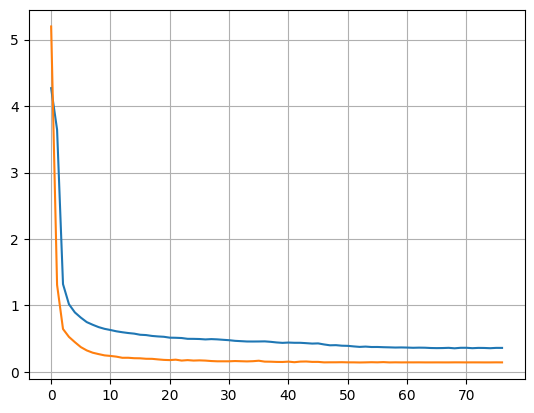

In [4]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [5]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes).to(DIVICE)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        train_mess.extend(mess)

        logits = model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        val_mess.extend(mess)

        logits= model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 64, 16, 89])
CNN число фичей: 1024
Проекция из 1024 в 1024
Mean accurasu by The Levenshtein in train is : 0.8932685114069244
Mean accurasu by The Levenshtein in validate is : 0.9503369680701127


# Сбор sample_submission

In [ ]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu()
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy()

    for ind in max_inds:
        merged_inds = []
        prev_idx = None
        for idx in ind:
            if idx != blank_label_idx and idx != prev_idx:
                merged_inds.append(idx)
            prev_idx = idx
        text = "".join([int_char_map.get(i, '') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes).to(DIVICE)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        train_mess.extend(mess)

        logits = model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq,seq_lens, test_target, _, mess = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)
        val_mess.extend(mess)

        logits= model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")


test_ds = MosreDatasetToTest(df=sample_data,
                        data_patch=SAVE_DIR/'test',
                        char_to_int=char_to_int,
                        train=False)

def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    # spec_lens = torch.stack([item[0] for item in batch])
    spec_lens = torch.tensor([item[1] for item in batch]).reshape(20)
    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[2] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[3] for item in batch])
        msg = [item[4] for item in batch]
        
        return [spectrograms_padded, spec_lens, target, label_len, msg]
    else: 
        return [spectrograms_padded, spec_lens]
    
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()
next(iter(test_dl))
with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq, seq_lens = loader
        seq = seq.to(DIVICE)
        seq_lens = seq_lens.to(DIVICE)

        logits = model_load(seq,seq_lens)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 64, 16, 89])
CNN число фичей: 1024
Проекция из 1024 в 1024
Mean accurasu by The Levenshtein in train is : 0.9066151537313227
Mean accurasu by The Levenshtein in validate is : 0.9661893167521509
